In [ ]:
"""
parameters:
    csv_data: all data
    signal_len = 1*22051
    record_len = 26
    batch_size = 32
    epochs = 500
    optimizer = Adam(lr=5e-4)
    scheduler = None
"""

In [1]:
import json, tempfile
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from tqdm import tqdm
from pathlib import Path
from datetime import datetime
from torchinfo import summary
from sklearn.metrics import confusion_matrix

import torch
from torch import nn, optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

In [2]:
data_dir = Path(r'..\dataset\training\npz_fft')
data_json = r'..\dataset\training\data_list_20230420.json'

In [3]:
with open(data_json) as f:
    data_files = json.load(f)
        
data_num = [[len(i) for i in v.values()] for v in data_files.values()]
df = pd.DataFrame(data_num)
df.index = [k for k in data_files.keys()]
df.columns = ['Phonotrauma', 'Incomplete glottic closure', 'Vocal Palsy', 'Neoplasm', 'Normal']
df.loc['total'] = df.sum(axis=0)
df.loc[:, 'total'] = df.sum(axis=1)
df

,Phonotrauma,Incomplete glottic closure,Vocal Palsy,Neoplasm,Normal,total
train,375,154,117,30,22,698
test,161,66,51,14,10,302
total,536,220,168,44,32,1000


In [4]:
n_sample = sum(data_num[0]) # num of training data
n_class = len(data_num[0]) # num of class
class_weight = torch.tensor([n_sample/(n_class*i) for i in data_num[0]]).cuda() # calculate class weight
class_weight

tensor([0.3723, 0.9065, 1.1932, 4.6533, 6.3455], device='cuda:0')

In [5]:
train_files, test_files = [], []
for v in data_files['train'].values():
    train_files += v

for v in data_files['test'].values():
    test_files += v

In [6]:
signal_len = 1*22051 # length of signal
record_len = 26 # length of record

def z_score(x):
    return (x-x.mean())/x.std()

def read_csv_data(csv_data):
    record = []
    for k, v in csv_data.items():
        if k == 'ID':
            continue
        elif k == 'Disease category':
            label = int(v)-1 # 1~5 to 0~4
            continue
        elif k == 'Sex':
            v = float(v)-1 # 1~2 to 0~1
        elif k == 'Age':
            v = float(v)/50
        elif k == 'Voice handicap index - 10':
            v = float(v)/40
        else:
            v = float(v)
        record.append(v)
    record = z_score(np.array(record)).astype(np.float32)
    
    return record, label

def read_npz_file(file):
    npz_data = np.load(file, allow_pickle=True)
    signal = z_score(npz_data['signal']).astype(np.float32)
    record, label = read_csv_data(npz_data['csv_data'].item())
    
    return (signal, record), label

def cut_pad_signal(signal, length=signal_len, mode='middle'):
    if len(signal) > length:
        cut_len = len(signal)-length
        if mode == 'middle': # cut from middle
            mid = cut_len//2
            return signal[mid:mid+length]
        elif mode == 'random': # random cut
            rand = np.random.randint(cut_len)
            return signal[rand:rand+length]
    else:
        pad_len = length-len(signal)
        signal = np.pad(signal, (0, pad_len)) 
        return signal

In [7]:
train_info = {i: [] for i in ['input_data', 'label']}
test_info = {i: [] for i in ['input_data', 'label']}

for file in tqdm(train_files):
    input_data, label = read_npz_file(data_dir/file)
    train_info['input_data'].append(input_data)
    train_info['label'].append(label)

for file in tqdm(test_files):
    input_data, label = read_npz_file(data_dir/file)
    test_info['input_data'].append(input_data)
    test_info['label'].append(label)

100%|███████████████████████████████████████████████████████████████████████████████| 302/302 [00:00<00:00, 522.08it/s]


In [21]:
# set model name
time_stamp = datetime.now().strftime('_%Y%m%d_%H%M%S')
model_name = 'm202_MultiOutput'+time_stamp

In [8]:
# for reload model
model_name = 'm202_MultiOutput_20230518_114418'

In [22]:
from models import m202_MultiOutput
model = m202_MultiOutput(record_len).cuda()
print(model_name)

logs_tb_dir = Path('logs_tb', model_name)
logs_tb_dir.mkdir(parents=True, exist_ok=True)
logs_json_dir = Path('logs_json', model_name)
logs_json_dir.mkdir(parents=True, exist_ok=True)
weights_dir = Path('weights', model_name)
weights_dir.mkdir(parents=True, exist_ok=True)
results_dir = Path('results', model_name)
results_dir.mkdir(parents=True, exist_ok=True)

m202_MultiOutput_20230518_114418


In [23]:
class TrainingDataset(Dataset):
    def __init__(self, data_type, input_data, label):
        self.data_type = data_type
        self.input_data = input_data
        self.label = label
        
    def __getitem__(self, index):
        signal = self.input_data[index][0]
        record = self.input_data[index][1]
        if self.data_type == 'train':
            signal = cut_pad_signal(signal, mode='random') # fixed length, random cut
            signal = -signal if np.random.rand() < .5 else signal # 隨機振幅反轉
        elif self.data_type == 'test':
            signal = cut_pad_signal(signal) # fixed length
            
        signal = torch.tensor(signal, dtype=torch.float32).cuda().unsqueeze(0) # [channel, row]
        record = torch.tensor(record, dtype=torch.float32).cuda()
        label = torch.tensor(self.label[index], dtype=torch.int64).cuda()
        return (signal, record), label
    
    def __len__(self):
        return len(self.input_data)

In [24]:
batch_size = 32
train_data = DataLoader(TrainingDataset('train', train_info['input_data'], train_info['label']),
                        batch_size=batch_size, shuffle=True)
test_data = DataLoader(TrainingDataset('test', test_info['input_data'], test_info['label']),
                       batch_size=batch_size)

In [25]:
# show model summary
model_input, _ = train_data.dataset[0]
summary(model, [i.unsqueeze(0).size() for i in model_input])

Layer (type:depth-idx)                                                 Output Shape              Param #
Model                                                                  [1, 5]                    --
├─SignalClassifier: 1-1                                                [1, 64]                   --
│    └─Sequential: 2-1                                                 [1, 32, 917]              --
│    │    └─Sequential: 3-1                                            [1, 32, 3674]             448
│    │    └─Sequential: 3-2                                            [1, 32, 1836]             3,168
│    │    └─Sequential: 3-3                                            [1, 32, 917]              3,168
│    └─Sequential: 2-2                                                 [1, 64, 116]              --
│    │    └─CSPNetBlock: 3-4                                           [1, 32, 459]              5,044
│    │    └─CSPNetBlock: 3-5                                           [1, 64, 230]  

In [26]:
# draw model graph
writer = SummaryWriter(logs_tb_dir, filename_suffix='-model_graph.tb')
model_input, _ = train_data.dataset[0]
writer.add_graph(model, [i.unsqueeze(0) for i in model_input])
writer.close()

In [27]:
def calc_uar(cm):
    cls_num = cm.shape[0]
    total_recall = 0
    
    for i in range(cls_num):
        TP = cm[i, i]
        FN = np.sum(cm[i, :])-TP
        total_recall += TP/(TP+FN) if TP != 0 else 0 # sensitivity (recall)
    uar = total_recall/cls_num # unweighted average recall
    
    return uar

def start_training(epochs, optimizer, scheduler=None, st_epoch=1, save_step=100, best_loss=[10., 10., 10.], best_uar=[0., 0., 0.]):
    '''
    multi-output:
        outputs[0]: Model outputs
        outputs[1]: SignalClassifier outputs
        outputs[2]: RecordClassifier outputs
    '''
    fn_epoch = st_epoch+epochs-1 # final epoch
    len_fn_epoch = len(str(fn_epoch)) # length of final epoch text
    pbar_colors = {'train': 'yellow', 'test': 'green'} # colors of progress bar
    logs = [{'train_loss': [], 'train_uar': [], 'test_loss': [], 'test_uar': []} for _ in range(3)] # for json logs
    writer = [SummaryWriter(logs_tb_dir, filename_suffix=f'-training_logs-{i}.tb') for i in range(3)] # for tb logs
    criterion = nn.CrossEntropyLoss(weight=class_weight) # for weighted CE loss calculation
    
    for e in range(epochs):
        cr_epoch = st_epoch+e # current epoch
        for p, phase in enumerate(['train', 'test']):
            data_num, running_loss = 0, [0., 0., 0.]
            all_labels, all_preds = [], [[], [], []]
            
            if p == 0:
                model.train() # training mode
                batch_data = train_data
            elif p == 1:
                model.eval() # evaluation mode
                batch_data = test_data

            pbar = tqdm(batch_data, unit='batch', # custom progress bar
                        desc=f'{cr_epoch:0>{len_fn_epoch}}/{fn_epoch} - {phase:>5}: ', colour=pbar_colors[phase])
            
            for b, batch in enumerate(pbar):
                inputs, labels = batch
                data_num += inputs[0].size(0)
                
                if p == 0:
                    optimizer.zero_grad() # clear gradients of optimizer
                    outputs = model(inputs[0], inputs[1]) # forward
                    loss = [criterion(op, labels) for op in outputs] # calculate loss
                    preds = [torch.max(op.data, 1)[1] for op in outputs] # get predicted results
                    sum(loss).backward() # calculate gradients
                    optimizer.step() # update weights
                    
                elif p == 1:
                    with torch.no_grad(): # don't calculate gradients in test
                        outputs = model(inputs[0], inputs[1])
                        loss = [criterion(op, labels) for op in outputs]
                        preds = [torch.max(op.data, 1)[1] for op in outputs]
                
                all_labels += labels.tolist()
                for i in range(3):
                    running_loss[i] += loss[i].item()*inputs[0].size(0)
                    all_preds[i] += preds[i].tolist()
                
                if b == len(pbar)-1:
                    current_loss = [running_loss[i]/data_num for i in range(3)] # calculate current loss
                    current_uar = [calc_uar(confusion_matrix(all_labels, all_preds[i])) for i in range(3)] # calculate current UAR
                    pbar.set_postfix_str(f'loss: {current_loss[0]:.4f}, uar: {current_uar[0]:.4f}')
            
            if p == 0:
                record_phase = 'Training'
                weights = model.state_dict()
                torch.save(weights, weights_dir/'last.pth') # save last weights
                if cr_epoch%save_step == 0: # save weights when reached step
                    torch.save(weights, weights_dir/f'epoch_{cr_epoch}.pth')
                    
            elif p == 1:
                record_phase = 'Testing'
                for i in range(3):
                    if current_loss[i] < best_loss[i]:
                        best_loss[i] = current_loss[i]
                        torch.save(weights, weights_dir/f'best_loss-{i}.pth') # save lowest loss weights
                    if current_uar[i] > best_uar[i]:
                        best_uar[i] = current_uar[i]
                        torch.save(weights, weights_dir/f'best_uar-{i}.pth') # save highest UAR weights
            
            # save training logs
            for i in range(3):
                writer[i].add_scalar(f'Loss/{record_phase}', current_loss[i], cr_epoch)
                writer[i].add_scalar(f'UAR/{record_phase}', current_uar[i], cr_epoch)    
                logs[i][f'{phase}_loss'].append(current_loss[i])
                logs[i][f'{phase}_uar'].append(current_uar[i])
            with open(logs_json_dir/f'epoch_{st_epoch}-{fn_epoch}.json', 'w') as f:
                json.dump(logs, f)
 
        if scheduler:
            scheduler.step() # update scheduler
    
    for i in range(3):
        writer[i].close()
    print(f"{' Training finished. ':=^80}")
    print(f"{f' best loss: {[round(loss, 4) for loss in best_loss]}, best uar: {[round(uar, 4) for uar in best_uar]} ':-^80}")
    
    return logs

In [28]:
# training from begining
epochs = 500
optimizer = optim.Adam(model.parameters(), 5e-4)

logs = start_training(epochs, optimizer)

500/500 -  test: 100%|███████████████████████████████████| 10/10 [00:00<00:00, 92.84batch/s, loss: 1.4766, uar: 0.3916]

============================== Training finished. ==============================
--- best loss: [0.9464, 1.3199, 1.0198], best uar: [0.6015, 0.4589, 0.5741] ----


In [ ]:
# training from trained weights
trained_epoch = max([int(f.stem.split('_')[1]) for f in weights_dir.glob('epoch_*.pth')]) # final epoch
model.load_state_dict(torch.load(weights_dir/f'epoch_{trained_epoch}.pth')) # trained weights

epochs = 500
optimizer = optim.Adam(model.parameters(), 5e-4)

# best_loss 和 best_uar 從上方儲存格最後的輸出取得
logs = start_training(epochs, optimizer, st_epoch=trained_epoch+1, best_loss=[0.9464, 1.3199, 1.0198], best_uar=[0.6015, 0.4589, 0.5741])

In [29]:
def show_training_log(logs, epochs, st_epoch=1):
    plt.figure(figsize=(10, 5))
    for p, phase in enumerate(['loss', 'uar']):
        plt.subplot(1, 2, p+1)
        plt.plot(range(st_epoch, st_epoch+epochs), logs['train_'+phase])
        plt.plot(range(st_epoch, st_epoch+epochs), logs['test_'+phase])
        
        plt.xlabel('Epoch')
        if p == 0:
            plt.ylabel('Loss')
        elif p == 1:
            plt.ylabel('UAR')
        plt.legend(['Training','Testing'], loc='upper left')
        
    plt.tight_layout()
    plt.show()

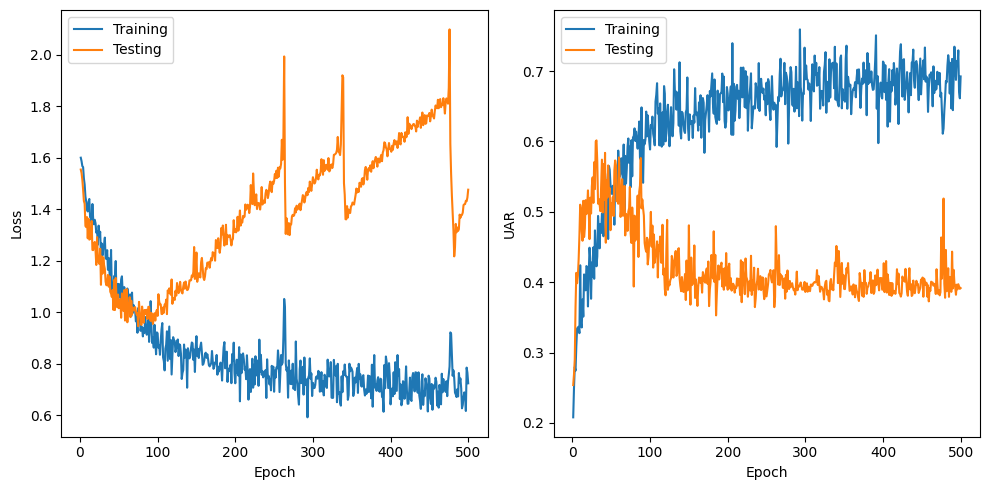

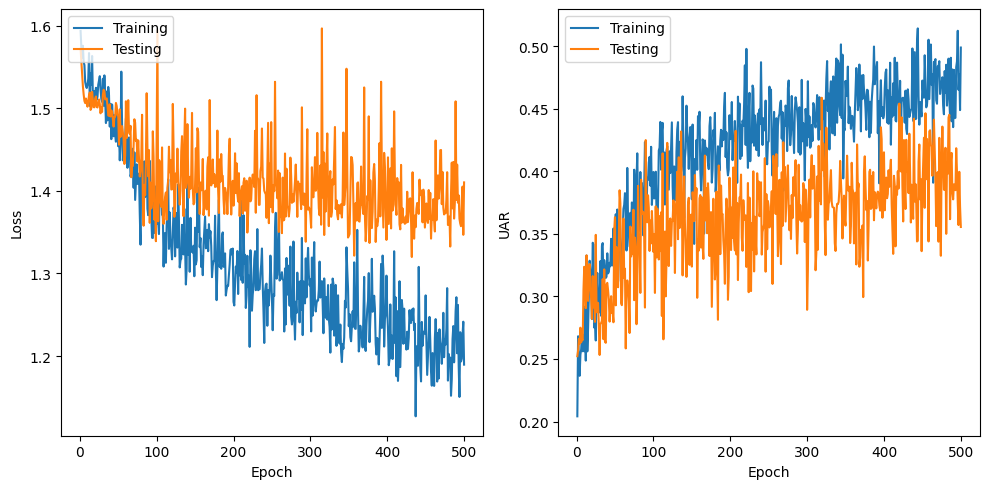

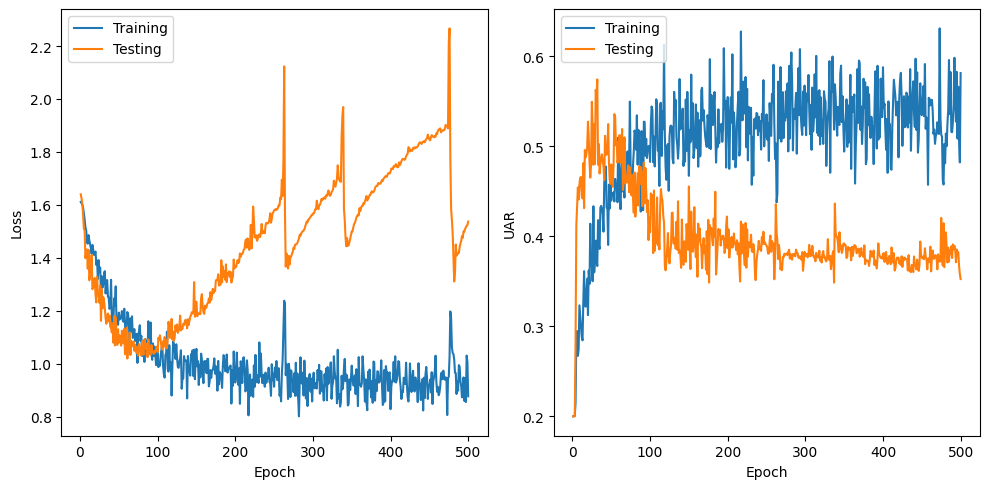

In [30]:
for lg in logs:
    show_training_log(lg, epochs)

In [ ]:
show_training_log(logs, epochs, trained_epoch+1)

In [31]:
def calc_metric(cm):
    total_TP = 0
    total_recall = 0
    cls_num = cm.shape[0]
    all_num = np.sum(cm)
    
    for i in range(cls_num):
        TP = cm[i, i]
        FN = np.sum(cm[i, :])-TP
        sen = TP/(TP+FN) if TP != 0 else 0 # sensitivity
        total_TP += TP
        total_recall += sen
        
    acc = total_TP/all_num # accuracy
    uar = total_recall/cls_num # unweighted average recall
    
    return (acc, uar)

def start_evaluate():
    model.eval()
    results = {}
    
    for p, phase in enumerate(['train', 'test']):
        all_labels, all_preds = [], [[], [], []]

        if p == 0:
            batch_data = train_data
        elif p == 1:
            batch_data = test_data

        pbar = tqdm(batch_data, unit='batch', desc=f'{phase:>5}: ')
        for b, batch in enumerate(pbar):
            inputs, labels = batch

            with torch.no_grad():
                outputs = model(inputs[0], inputs[1])
                preds = [torch.max(op, 1)[1] for op in outputs]

            all_labels += labels.tolist()
            for i in range(3):
                all_preds[i] += preds[i].tolist()
                
            if b == len(pbar)-1:
                metrics = [calc_metric(confusion_matrix(all_labels, all_preds[i])) for i in range(3)]
                pbar.set_postfix_str(f'acc: {[round(m[0], 4) for m in metrics]}, uar: {[round(m[1], 4) for m in metrics]}')

        results[phase] = {'labels': all_labels, 'preds': all_preds}

    return results

In [32]:
def calc_score(cm):
    scores = []
    total_TP = 0
    total_recall = 0
    cls_num = cm.shape[0]
    all_num = np.sum(cm)
    
    for i in range(cls_num):
        TP = cm[i, i]
        FP = np.sum(cm[:, i])-TP
        FN = np.sum(cm[i, :])-TP
        TN = all_num-FN-FP+TP
        
        pre = TP/(TP+FP) if TP != 0 else 0 # precision
        sen = TP/(TP+FN) if TP != 0 else 0 # sensitivity
        spe = TN/(TN+FP) if TN != 0 else 0 # specificity
        F1 = 2*(pre*sen)/(pre+sen) if pre+sen != 0 else 0 # F1-score
        scores.append({'pre': pre, 'sen': sen, 'spe': spe, 'F1': F1})
        
        total_TP += TP
        total_recall += sen
        
    acc = total_TP/all_num # accuracy
    uar = total_recall/cls_num # unweighted average recall
    
    return scores, acc, uar

def show_confusion_matrix(result_type, phase, labels, preds):
    fig = plt.figure(figsize=(5, 5))
    if phase == 'train':
        record_phase = 'Training'
    elif phase == 'test':
        record_phase = 'Testing'
    print(f'{record_phase}:')
    
    cm = confusion_matrix(labels, preds)
    scores, acc, uar = calc_score(cm)
    
    fontsize = 18
    font = {'family': 'Times New Roman', 'size': fontsize}
    plt.rc('font', **font)
    ax = sn.heatmap(cm, annot=True, annot_kws={'size': fontsize}, cmap='Blues', cbar=False, fmt='',
                    linewidths=.5, linecolor='black', clip_on=False)
    ax.set_ylabel('Label', fontweight='bold', fontsize=fontsize)
    ax.set_title('Predicted', fontweight='bold', fontsize=fontsize)
    ax.xaxis.tick_top()
    
    print(f'Accuracy: {acc*100:.2f}%')
    print(f'UAR: {uar*100:.2f}%')
    print(f"{'Class'}{'Precision':>11}{'Sensitivity':>13}{'Specificity':>13}{'F1-score':>10}")
    for i in range(len(scores)):
        cls_scores = scores[i]
        print(f"{i:>5}{cls_scores['pre']:>11.4f}{cls_scores['sen']:>13.4f}"+
              f"{cls_scores['spe']:>13.4f}{cls_scores['F1']:>10.4f}")
    
    plt.tight_layout()
    plt.show()
    writer.add_figure(f'Confusion Matrix ({result_type})/{record_phase}', fig)

In [33]:
class EvaluationDataset(Dataset):
    def __init__(self, data_type, input_data, label):
        self.data_type = data_type
        self.input_data = input_data
        self.label = label
        
    def __getitem__(self, index):
        signal = self.input_data[index][0]
        record = self.input_data[index][1]
        if self.data_type == 'fixed': # fixed length
            signal = torch.tensor(cut_pad_signal(signal), dtype=torch.float32).cuda().unsqueeze(0)
        elif self.data_type == 'original': # original length
            signal = torch.tensor(signal, dtype=torch.float32).cuda().unsqueeze(0)
            
        record = torch.tensor(record, dtype=torch.float32).cuda()
        label = torch.tensor(self.label[index], dtype=torch.int64).cuda()
        return (signal, record), label
    
    def __len__(self):
        return len(self.input_data)

In [34]:
# fixed length results
batch_size = 64
train_data = DataLoader(EvaluationDataset('fixed', train_info['input_data'], train_info['label']),
                        batch_size=batch_size)
test_data = DataLoader(EvaluationDataset('fixed', test_info['input_data'], test_info['label']),
                       batch_size=batch_size)

In [35]:
results = {}
weights_file = [file.stem for file in weights_dir.glob('*.pth') if file.stem != 'last']
for fname in weights_file:
    print(f'{fname}:')
    model.load_state_dict(torch.load(weights_dir/f'{fname}.pth'))
    results[fname] = start_evaluate()

with open(results_dir/'fixed_length.json', 'w') as f:
     json.dump(results, f)

best_loss-0:


 test: 100%|█████████████| 5/5 [00:00<00:00, 42.13batch/s, acc: [0.6556, 0.3311, 0.5993], uar: [0.4691, 0.297, 0.4668]]


best_loss-1:


 test: 100%|█████████████| 5/5 [00:00<00:00, 62.67batch/s, acc: [0.5795, 0.3907, 0.5629], uar: [0.3807, 0.3826, 0.362]]


best_loss-2:


 test: 100%|██████████████| 5/5 [00:00<00:00, 62.64batch/s, acc: [0.6258, 0.4536, 0.6093], uar: [0.54, 0.3623, 0.5123]]


best_uar-0:


 test: 100%|████████████| 5/5 [00:00<00:00, 62.67batch/s, acc: [0.5397, 0.2781, 0.5298], uar: [0.6015, 0.2782, 0.5541]]


best_uar-1:


 test: 100%|████████████| 5/5 [00:00<00:00, 65.11batch/s, acc: [0.5695, 0.3278, 0.5497], uar: [0.3865, 0.4589, 0.3727]]


best_uar-2:


 test: 100%|████████████| 5/5 [00:00<00:00, 62.64batch/s, acc: [0.5265, 0.2483, 0.5497], uar: [0.5713, 0.2786, 0.5741]]


epoch_100:


 test: 100%|██████████████| 5/5 [00:00<00:00, 66.00batch/s, acc: [0.649, 0.245, 0.6258], uar: [0.4631, 0.3344, 0.4044]]


epoch_200:


 test: 100%|█████████████| 5/5 [00:00<00:00, 52.22batch/s, acc: [0.5762, 0.3377, 0.543], uar: [0.3893, 0.3713, 0.3869]]


epoch_300:


 test: 100%|████████████| 5/5 [00:00<00:00, 64.27batch/s, acc: [0.5662, 0.3411, 0.5662], uar: [0.3861, 0.2893, 0.3807]]


epoch_400:


 test: 100%|██████████████| 5/5 [00:00<00:00, 65.11batch/s, acc: [0.5828, 0.3477, 0.5629], uar: [0.39, 0.4152, 0.3804]]


epoch_500:


 test: 100%|████████████| 5/5 [00:00<00:00, 65.14batch/s, acc: [0.5762, 0.3543, 0.5397], uar: [0.3916, 0.3555, 0.3524]]


In [36]:
# for reload results
with open(results_dir/'fixed_length.json', 'r') as f:
     results = json.load(f)

Outputs[0]:
Training:
Accuracy: 62.03%
UAR: 72.96%
Class  Precision  Sensitivity  Specificity  F1-score
    0     0.9091       0.5867       0.9712    0.7131
    1     0.5470       0.6429       0.8895    0.5910
    2     0.8250       0.5641       0.9804    0.6701
    3     0.2477       0.9000       0.8864    0.3885
    4     0.2442       0.9545       0.9095    0.3889


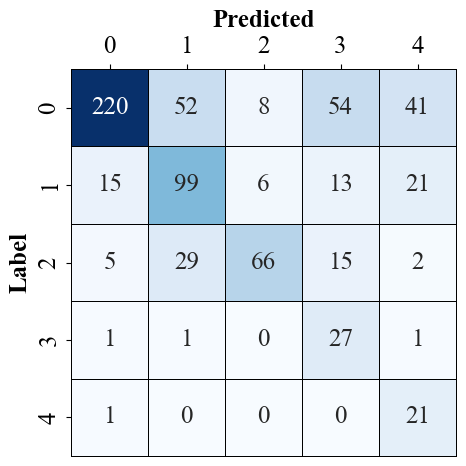

Outputs[1]:
Training:
Accuracy: 30.66%
UAR: 35.07%
Class  Precision  Sensitivity  Specificity  F1-score
    0     0.6174       0.3787       0.8550    0.4694
    1     0.3784       0.0909       0.9598    0.1466
    2     0.6604       0.2991       0.9724    0.4118
    3     0.0649       0.1667       0.8938    0.0935
    4     0.0598       0.8182       0.6025    0.1115


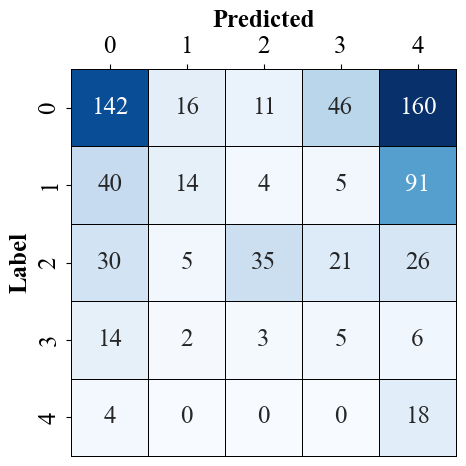

Outputs[2]:
Training:
Accuracy: 57.45%
UAR: 70.23%
Class  Precision  Sensitivity  Specificity  F1-score
    0     0.8943       0.5413       0.9671    0.6744
    1     0.5137       0.4870       0.8977    0.5000
    2     0.6972       0.6496       0.9550    0.6726
    3     0.2049       0.8333       0.8649    0.3289
    4     0.2340       1.0000       0.9000    0.3793


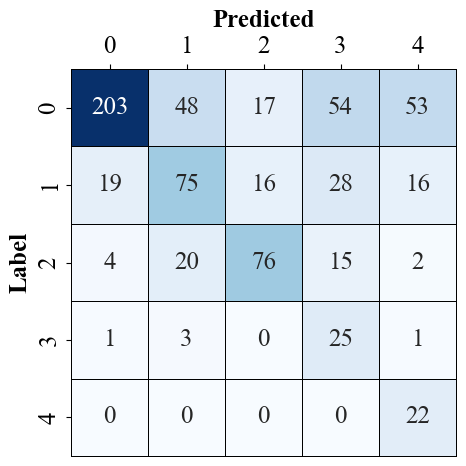

Outputs[0]:
Testing:
Accuracy: 53.97%
UAR: 60.15%
Class  Precision  Sensitivity  Specificity  F1-score
    0     0.8529       0.5404       0.9524    0.6616
    1     0.4667       0.5303       0.8693    0.4965
    2     0.7931       0.4510       0.9798    0.5750
    3     0.2391       0.7857       0.8871    0.3667
    4     0.1400       0.7000       0.8595    0.2333


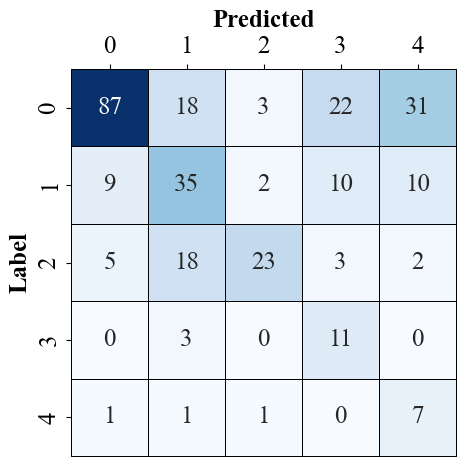

Outputs[1]:
Testing:
Accuracy: 27.81%
UAR: 27.82%
Class  Precision  Sensitivity  Specificity  F1-score
    0     0.5631       0.3602       0.8249    0.4394
    1     0.1500       0.0455       0.9298    0.0698
    2     0.5926       0.3137       0.9611    0.4103
    3     0.0357       0.0714       0.9069    0.0476
    4     0.0484       0.6000       0.6118    0.0896


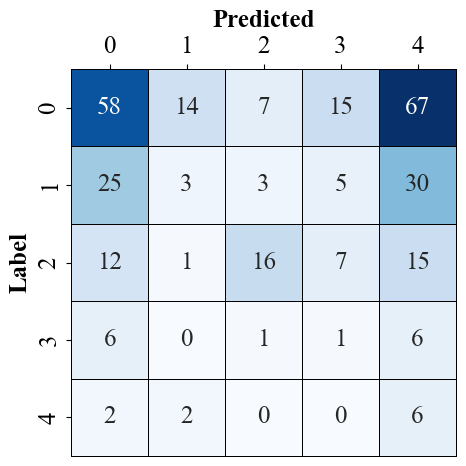

Outputs[2]:
Testing:
Accuracy: 52.98%
UAR: 55.41%
Class  Precision  Sensitivity  Specificity  F1-score
    0     0.8738       0.5590       0.9595    0.6818
    1     0.5000       0.4697       0.8960    0.4844
    2     0.6000       0.4706       0.9465    0.5275
    3     0.1739       0.5714       0.8750    0.2667
    4     0.1373       0.7000       0.8562    0.2295


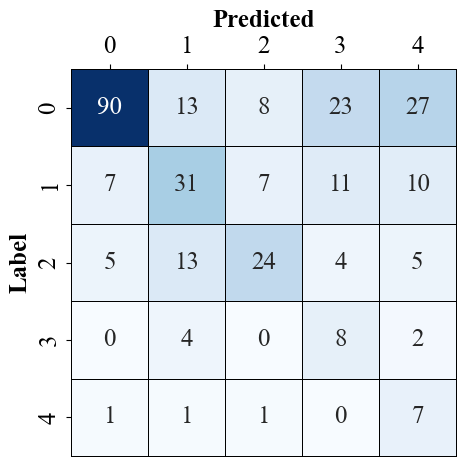

In [37]:
# output[0] best uar
writer = SummaryWriter(logs_tb_dir, filename_suffix='-CM_fixed_len-0.tb')
chosen_result = results['best_uar-0']
for k, v in chosen_result.items():
    for i in range(3):
        print(f'Outputs[{i}]:')
        show_confusion_matrix('Fixed Length', k, v['labels'], v['preds'][i])
writer.close()

Outputs[0]:
Training:
Accuracy: 99.71%
UAR: 99.82%
Class  Precision  Sensitivity  Specificity  F1-score
    0     1.0000       0.9973       1.0000    0.9987
    1     1.0000       0.9935       1.0000    0.9967
    2     0.9915       1.0000       0.9988    0.9957
    3     1.0000       1.0000       1.0000    1.0000
    4     0.9565       1.0000       0.9986    0.9778


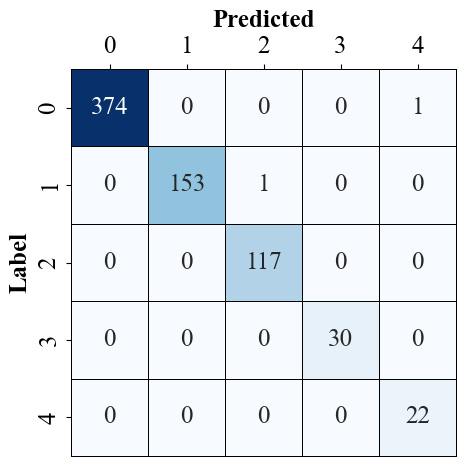

Outputs[1]:
Training:
Accuracy: 36.25%
UAR: 47.31%
Class  Precision  Sensitivity  Specificity  F1-score
    0     0.6507       0.2533       0.9006    0.3647
    1     0.3667       0.3571       0.8547    0.3618
    2     0.3169       0.6581       0.7741    0.4278
    3     0.0972       0.2333       0.9047    0.1373
    4     0.2184       0.8636       0.9048    0.3486


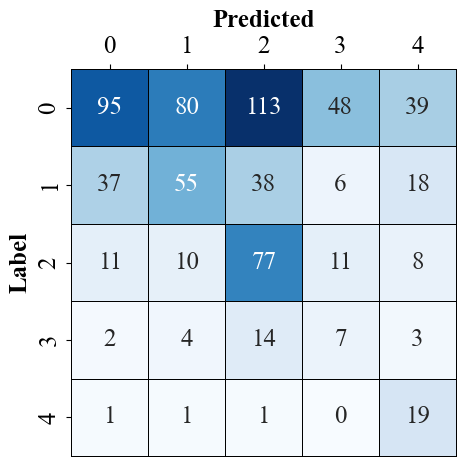

Outputs[2]:
Training:
Accuracy: 100.00%
UAR: 100.00%
Class  Precision  Sensitivity  Specificity  F1-score
    0     1.0000       1.0000       1.0000    1.0000
    1     1.0000       1.0000       1.0000    1.0000
    2     1.0000       1.0000       1.0000    1.0000
    3     1.0000       1.0000       1.0000    1.0000
    4     1.0000       1.0000       1.0000    1.0000


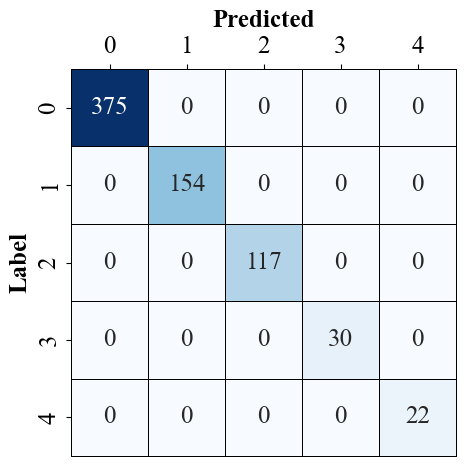

Outputs[0]:
Testing:
Accuracy: 56.95%
UAR: 38.65%
Class  Precision  Sensitivity  Specificity  F1-score
    0     0.7516       0.7143       0.8976    0.7325
    1     0.3582       0.3636       0.8486    0.3609
    2     0.5088       0.5686       0.9094    0.5370
    3     0.2000       0.2857       0.9459    0.2353
    4     0.0000       0.0000       0.9829    0.0000


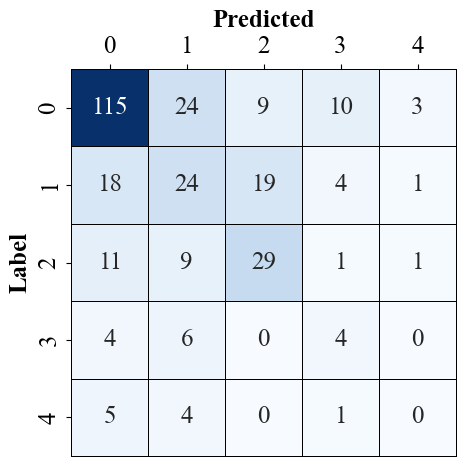

Outputs[1]:
Testing:
Accuracy: 32.78%
UAR: 45.89%
Class  Precision  Sensitivity  Specificity  F1-score
    0     0.6140       0.2174       0.8957    0.3211
    1     0.2338       0.2727       0.7831    0.2517
    2     0.3474       0.6471       0.8044    0.4521
    3     0.1471       0.3571       0.9027    0.2083
    4     0.2051       0.8000       0.8994    0.3265


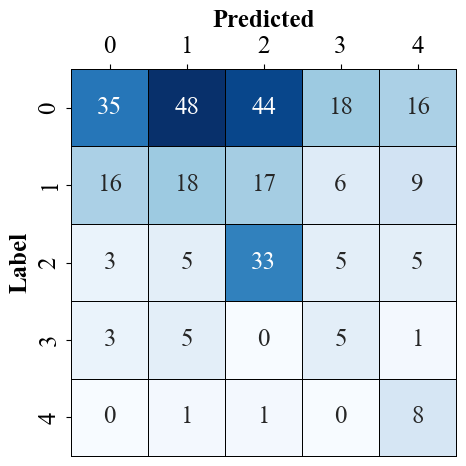

Outputs[2]:
Testing:
Accuracy: 54.97%
UAR: 37.27%
Class  Precision  Sensitivity  Specificity  F1-score
    0     0.7467       0.6957       0.8959    0.7203
    1     0.3188       0.3333       0.8321    0.3259
    2     0.5000       0.5490       0.9088    0.5234
    3     0.2222       0.2857       0.9527    0.2500
    4     0.0000       0.0000       0.9692    0.0000


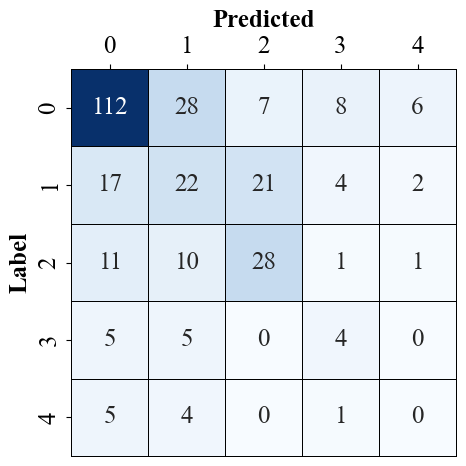

In [38]:
# output[1] best uar
writer = SummaryWriter(logs_tb_dir, filename_suffix='-CM_fixed_len-1.tb')
chosen_result = results['best_uar-1']
for k, v in chosen_result.items():
    for i in range(3):
        print(f'Outputs[{i}]:')
        show_confusion_matrix('Fixed Length', k, v['labels'], v['preds'][i])
writer.close()

Outputs[0]:
Training:
Accuracy: 59.74%
UAR: 67.98%
Class  Precision  Sensitivity  Specificity  F1-score
    0     0.8971       0.5813       0.9671    0.7055
    1     0.4769       0.6039       0.8603    0.5330
    2     0.8312       0.5470       0.9817    0.6598
    3     0.2778       0.6667       0.9266    0.3922
    4     0.1982       1.0000       0.8764    0.3308


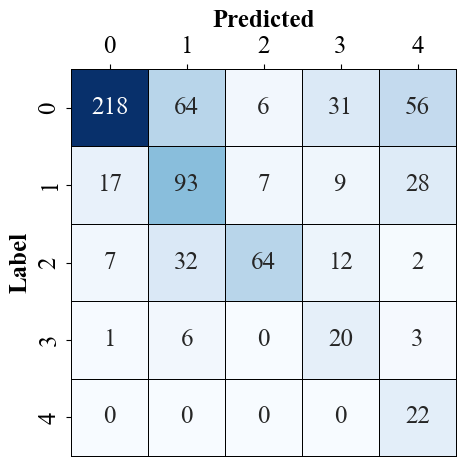

Outputs[1]:
Training:
Accuracy: 26.79%
UAR: 33.24%
Class  Precision  Sensitivity  Specificity  F1-score
    0     0.6230       0.3173       0.8717    0.4205
    1     0.1739       0.0779       0.8996    0.1076
    2     0.6875       0.2821       0.9768    0.4000
    3     0.0806       0.1667       0.9159    0.1087
    4     0.0549       0.8182       0.5646    0.1029


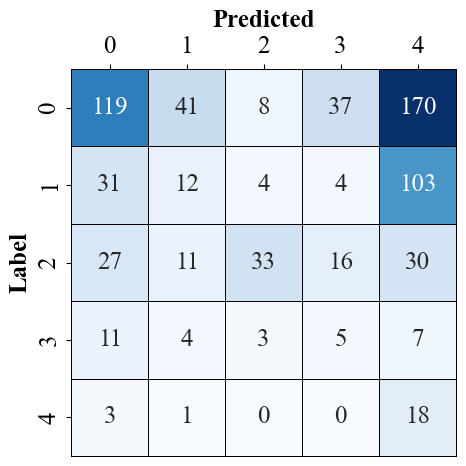

Outputs[2]:
Training:
Accuracy: 58.60%
UAR: 68.73%
Class  Precision  Sensitivity  Specificity  F1-score
    0     0.8966       0.5547       0.9675    0.6853
    1     0.5190       0.5325       0.8927    0.5256
    2     0.7037       0.6496       0.9563    0.6756
    3     0.2258       0.7000       0.8986    0.3415
    4     0.2056       1.0000       0.8819    0.3411


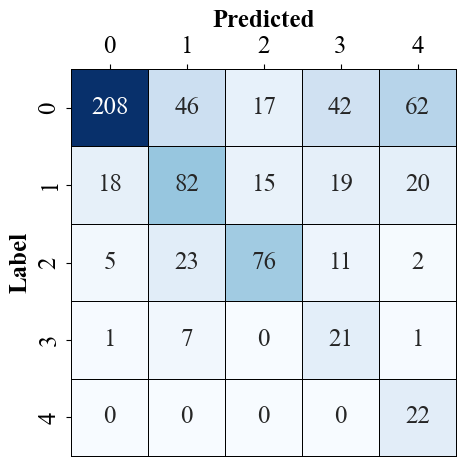

Outputs[0]:
Testing:
Accuracy: 52.65%
UAR: 57.13%
Class  Precision  Sensitivity  Specificity  F1-score
    0     0.8173       0.5280       0.9389    0.6415
    1     0.4928       0.5152       0.8849    0.5037
    2     0.7500       0.4706       0.9732    0.5783
    3     0.2250       0.6429       0.8987    0.3333
    4     0.1228       0.7000       0.8366    0.2090


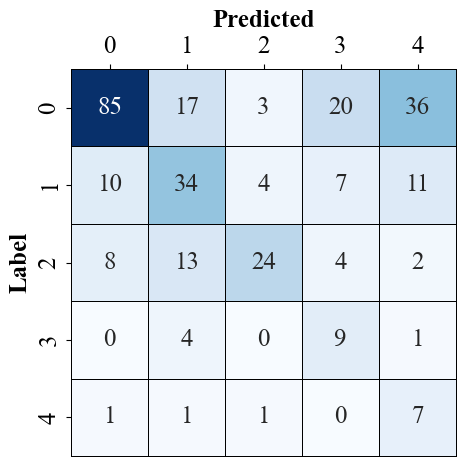

Outputs[1]:
Testing:
Accuracy: 24.83%
UAR: 27.86%
Class  Precision  Sensitivity  Specificity  F1-score
    0     0.5753       0.2609       0.8622    0.3590
    1     0.2895       0.1667       0.8953    0.2115
    2     0.6000       0.2941       0.9644    0.3947
    3     0.0385       0.0714       0.9138    0.0500
    4     0.0429       0.6000       0.5592    0.0800


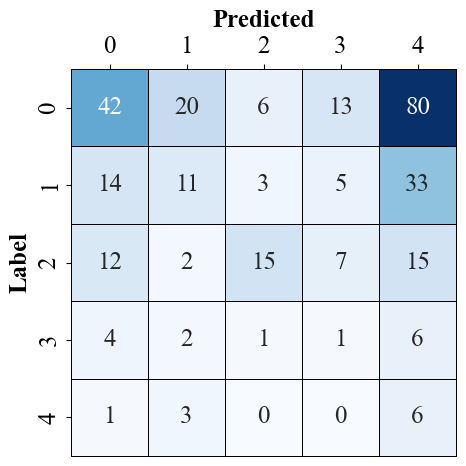

Outputs[2]:
Testing:
Accuracy: 54.97%
UAR: 57.41%
Class  Precision  Sensitivity  Specificity  F1-score
    0     0.8738       0.5590       0.9595    0.6818
    1     0.5385       0.5303       0.9020    0.5344
    2     0.6190       0.5098       0.9472    0.5591
    3     0.2051       0.5714       0.8980    0.3019
    4     0.1321       0.7000       0.8497    0.2222


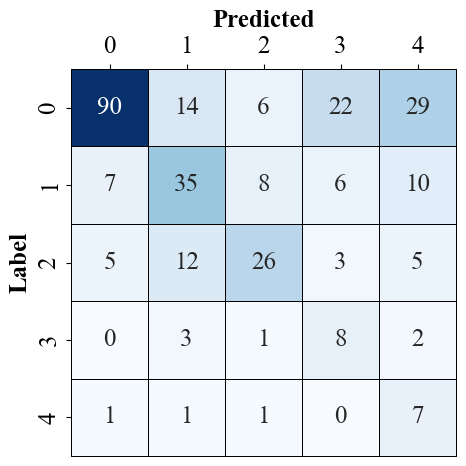

In [39]:
# output[2] best uar
writer = SummaryWriter(logs_tb_dir, filename_suffix='-CM_fixed_len-2.tb')
chosen_result = results['best_uar-2']
for k, v in chosen_result.items():
    for i in range(3):
        print(f'Outputs[{i}]:')
        show_confusion_matrix('Fixed Length', k, v['labels'], v['preds'][i])
writer.close()

In [ ]:
%load_ext tensorboard
%tensorboard --logdir logs_tb --reload_multifile True

tb_temp_dir = Path(tempfile.gettempdir(), '.tensorboard-info')
for tb_temp in tb_temp_dir.glob('*.info'):
    tb_temp.unlink(missing_ok=True)